In [2]:
import numpy as np
import os
import pandas as pd
import geopandas as gpd

from sklearn.linear_model import LinearRegression
from scipy.interpolate import griddata
import branca
import matplotlib.pyplot as plt
import geojsoncontour
import json
import xarray as xr
import datetime as dt
from matplotlib.cm import ScalarMappable
from matplotlib.figure import Figure
from scipy.spatial.distance import cdist

from sklearn.neighbors import NearestNeighbors
from geopandas import GeoDataFrame
from geovoronoi.plotting import subplot_for_map, plot_voronoi_polys_with_points_in_area
from geovoronoi import voronoi_regions_from_coords, points_to_coords
from shapely.geometry import Point

from shapely.ops import cascaded_union

from matplotlib.cm import ScalarMappable
import matplotlib as mpl
from shapely import geometry


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [5]:
p1 = geometry.Point(129.4088,1.5214)
p2 = geometry.Point(137.0541, 1.5214)
p3 = geometry.Point(137.0541,11.6587)
p4 = geometry.Point(129.4088,11.6587)

pointList = [p1, p2, p3, p4, p1]
poly = geometry.Polygon([[p.x, p.y] for p in pointList])

pdf = pd.DataFrame(
    {
        "id": ["Palau CRW Box"],
        "geometry": [poly
        ],
    }
)

gdf = gpd.GeoDataFrame(pdf, geometry="geometry")
print(gdf)

              id                                           geometry
0  Palau CRW Box  POLYGON ((129.40880 1.52140, 137.05410 1.52140...


In [6]:
boundary = gdf.set_crs(crs="EPSG:3395", allow_override=True)
boundary_shape = cascaded_union(boundary.geometry)

/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_48235/2726247839.py:2: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  boundary_shape = cascaded_union(boundary.geometry)


In [225]:
def getGridGeoJSON(df,variable_name):
#     df = palau_eez(df)
    df_slice = df


    coordinates = df_slice[['latitude','longitude',variable_name]]
    coordinates = coordinates.drop_duplicates()


    colors = ["#112513", "#183c27", "#195437","#106d44","#06874d","#2b9f51","#63b361","#8dc881","#b2dfa6","#d7f9d0" ]
    colors.reverse()
    levels = len(colors)
    vmin   = -4
    vmax   = 0.5
    tiers = np.logspace(start = -4,stop = 1,num = 11, base = 10).tolist()
    tiers = np.linspace(vmin,vmax,levels+1).tolist()

    tiers = np.arange(-4,1.5,0.5)
    
    df_slice = df_slice.sort_values(by=['longitude','latitude'], ascending=[False,True])
    df_slice['new_col'] = list(zip(df_slice.latitude, df_slice.longitude))#         coordinates = coordinates.drop_duplicates()
    coordinates = []

        
    for c in df_slice['new_col']:
        coordinates.append([c[0],c[1]])
    points = []
    for x in coordinates:
        points.append(Point(x[1],x[0]))
        
    points_gdf = GeoDataFrame(crs="EPSG:3395", geometry=points)
    in_palau = []
    
    for point in points_gdf.geometry:
        in_palau.append(point)
            
            
    points_gdf = GeoDataFrame(crs="EPSG:3395", geometry=in_palau)
    
    gdf_proj = points_gdf.to_crs(boundary.crs)

    coords = points_to_coords(gdf_proj.geometry)
    poly_shapes, pts = voronoi_regions_from_coords(coords, boundary_shape)
    voronoi_poly = GeoDataFrame(crs="EPSG:3395", geometry=list(poly_shapes.values()))
    
    longitude = []
    latitude = []
    for pt in pts:
        longitude.append(coords[pt][0])
        latitude.append(coords[pt][1])
    voronoi_poly["longitude"] = longitude
    voronoi_poly["latitude"] = latitude

    
    df_slice = df_slice.drop(['new_col'], axis=1)
    

    df_slice['geometry'] = voronoi_poly.sort_values(by=['longitude','latitude'], ascending=[False,True])['geometry'].tolist()
    df_slice = df_slice.reset_index()
    df_slice = df_slice.drop('index',axis=1)
    values = df_slice[variable_name].tolist()
    
    df_colors = []
    
    
    for v in values:
        
        for i in range(len(tiers)):
            if tiers[0] >= v:
                df_colors.append(colors[0])
                break
            if tiers[i] > v:
                df_colors.append(colors[i-1])
                break
            if tiers[-1] <= v:
                df_colors.append(colors[-1])
                break
            if np.isnan(v):
                df_colors.append("#00000000")
#                 df_colors.append("#000000")
                break

    
    df_slice['fill'] = df_colors
    
    voronoi_color = GeoDataFrame(df_slice[['geometry','fill']],crs="EPSG:3395")

    #Convert color to RGB

    R,G,B = [], [],[]
    for color in df_slice['fill'].tolist():
#         print(color)
        r,g,b = [int(str(color[1:])[i:i+2], 16) for i in (0, 2, 4)]
        R.append(r)
        G.append(g)
        B.append(b)
    df_slice['R'] = R
    df_slice['G'] = G
    df_slice['B'] = B
    
    json_gdf = GeoDataFrame(df_slice,crs="EPSG:3395")
    
    palau_land = gpd.read_file('../palau.geojson')
    palau_land = palau_land.drop(['type','id','tags','meta'],axis = 1)
    palau_land = palau_land[palau_land.geometry.type != 'LineString']
    
    trimmed = gpd.overlay(json_gdf,palau_land, how='difference')
        
#     trimmed = trimmed[["geometry",variable_name,"fill", "R", "G", "B" ]]
    
    
    #Plotting voronoi
    fig, ax = plt.subplots(figsize=(50, 50))
    boundary.plot(ax=ax, color="gray")
    trimmed.plot(ax=ax, color=trimmed["fill"])
#     points_gdf.plot(ax=ax, markersize=1, color="black")
    ax.axis("off")
    plt.axis('equal')
    plt.show()
    
#     print(trimmed)
    
    json_gdf = trimmed.to_json()
    
    
    return json.loads(json_gdf)

In [218]:
def colorbar_mpl(full_directory):
    
    colors = ["#112513", "#183c27", "#195437","#106d44","#06874d","#2b9f51","#63b361","#8dc881","#b2dfa6","#d7f9d0" ]
    colors.reverse()
    levels = len(colors)
#     vmin   = min(coordinates.tos.tolist())
#     vmax   = max(coordinates.tos.tolist())
    cmap = mpl.colors.ListedColormap(colors)
#     tiers = np.logspace(0,10,levels+1).tolist()
    tiers = np.logspace(start = -4,stop = 1,num = 11, base = 10).tolist()
#     tiers = [0.0001,0.001,0.01,0.1,1,10]
    
    bounds = [x for x in tiers]

    norm = mpl.colors.BoundaryNorm(bounds, ncolors=len(colors))
    
    cfig, ax = plt.subplots(figsize=(0.5,10))
#     cfig.subplots_adjust(bottom=0.5)
    cfig.colorbar(ScalarMappable(norm=norm, cmap=cmap),cax = ax, orientation='vertical', spacing='uniform',ticks = [0.0001,0.001,0.01,0.1,1,10],label="mg/m^3")
    
#     cfig.savefig(full_directory)
    cfig.savefig(full_directory,bbox_inches='tight', dpi=150)

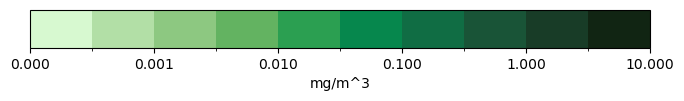

In [117]:
colorbar_mpl("./chlor_con_linear.png")

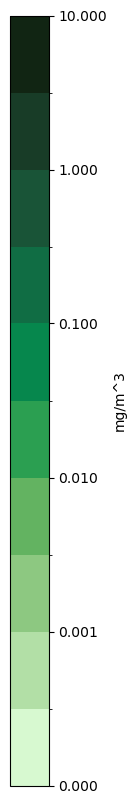

In [219]:
colorbar_mpl("./chlor_con_linear_v.png")

In [220]:
def colorbar_mpl_log(full_directory):
    colors = ['#112313',
 '#112413',
 '#112413',
 '#112513',
 '#142c19',
 '#16341f',
 '#183c27',
 '#19442c',
 '#194c31',
 '#195437',
 '#165c3b',
 '#13643f',
 '#106d44',
 '#0d7547',
 '#0a7e4a',
 '#06874d',
 '#10914e',
 '#1c994f',
 '#2b9f51',
 '#39aa51',
 '#48b352',
 '#63b361',
 '#71ba6b',
 '#7fc176',
 '#8dc881',
 '#99d08d',
 '#a5d899',
 '#b2dfa6',
 '#bdeab2',
 '#c9f3c0']
    colors.reverse()
    levels = len(colors)

    cmap = mpl.colors.ListedColormap(colors)

    tiers = np.logspace(start = -1.7371779278,stop = 0.434294481903,num = len(colors)+1, base = 10).tolist()

    bounds = [x for x in tiers]

    norm = mpl.colors.BoundaryNorm(bounds, ncolors=len(colors))
    
    cfig, ax = plt.subplots(figsize=(0.5,10))
#     cfig.subplots_adjust(bottom=0.5)
    cfig.colorbar(ScalarMappable(norm=norm, cmap=cmap),cax = ax, orientation='vertical', spacing='uniform',ticks = [0,10**-1,10**0])
    
#     cfig.savefig(full_directory)
    cfig.savefig(full_directory,bbox_inches='tight', dpi=150)

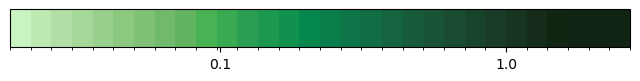

In [205]:
colorbar_mpl_log("./chlor_con_log.png")

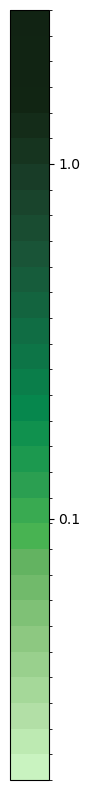

In [221]:
colorbar_mpl_log("./chlor_con_log_v.png")

In [7]:
ds = xr.open_dataset("../md50data/a50bd2a9c4f4e566799704213cf672af.nc")
sample_chlor_size = ds.to_dataframe()

In [8]:
sample_chlor_size = ds.to_dataframe()

In [10]:
sample_chlor_size=sample_chlor_size.reset_index().reset_index(drop= True)

In [9]:
ds = xr.open_dataset("../chlor_a/fa73c0b40614636c689737ba26ae299d.nc")

In [10]:
chlor_a = ds.to_dataframe()

In [11]:
chlor_a = chlor_a.reset_index()

In [12]:
chlor_a = chlor_a[['latitude','longitude','chlor_a']]

In [14]:
import math

In [15]:
chlor_a['chlor_a_base'] = np.log(chlor_a['chlor_a'])

In [185]:
log_space = np.logspace(start = min(chlor_a['chlor_a_base']),stop = max(chlor_a['chlor_a_base']),num = 11, base = 10).tolist()

/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_45374/1300637208.py:331: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf,palau_land, how='difference')


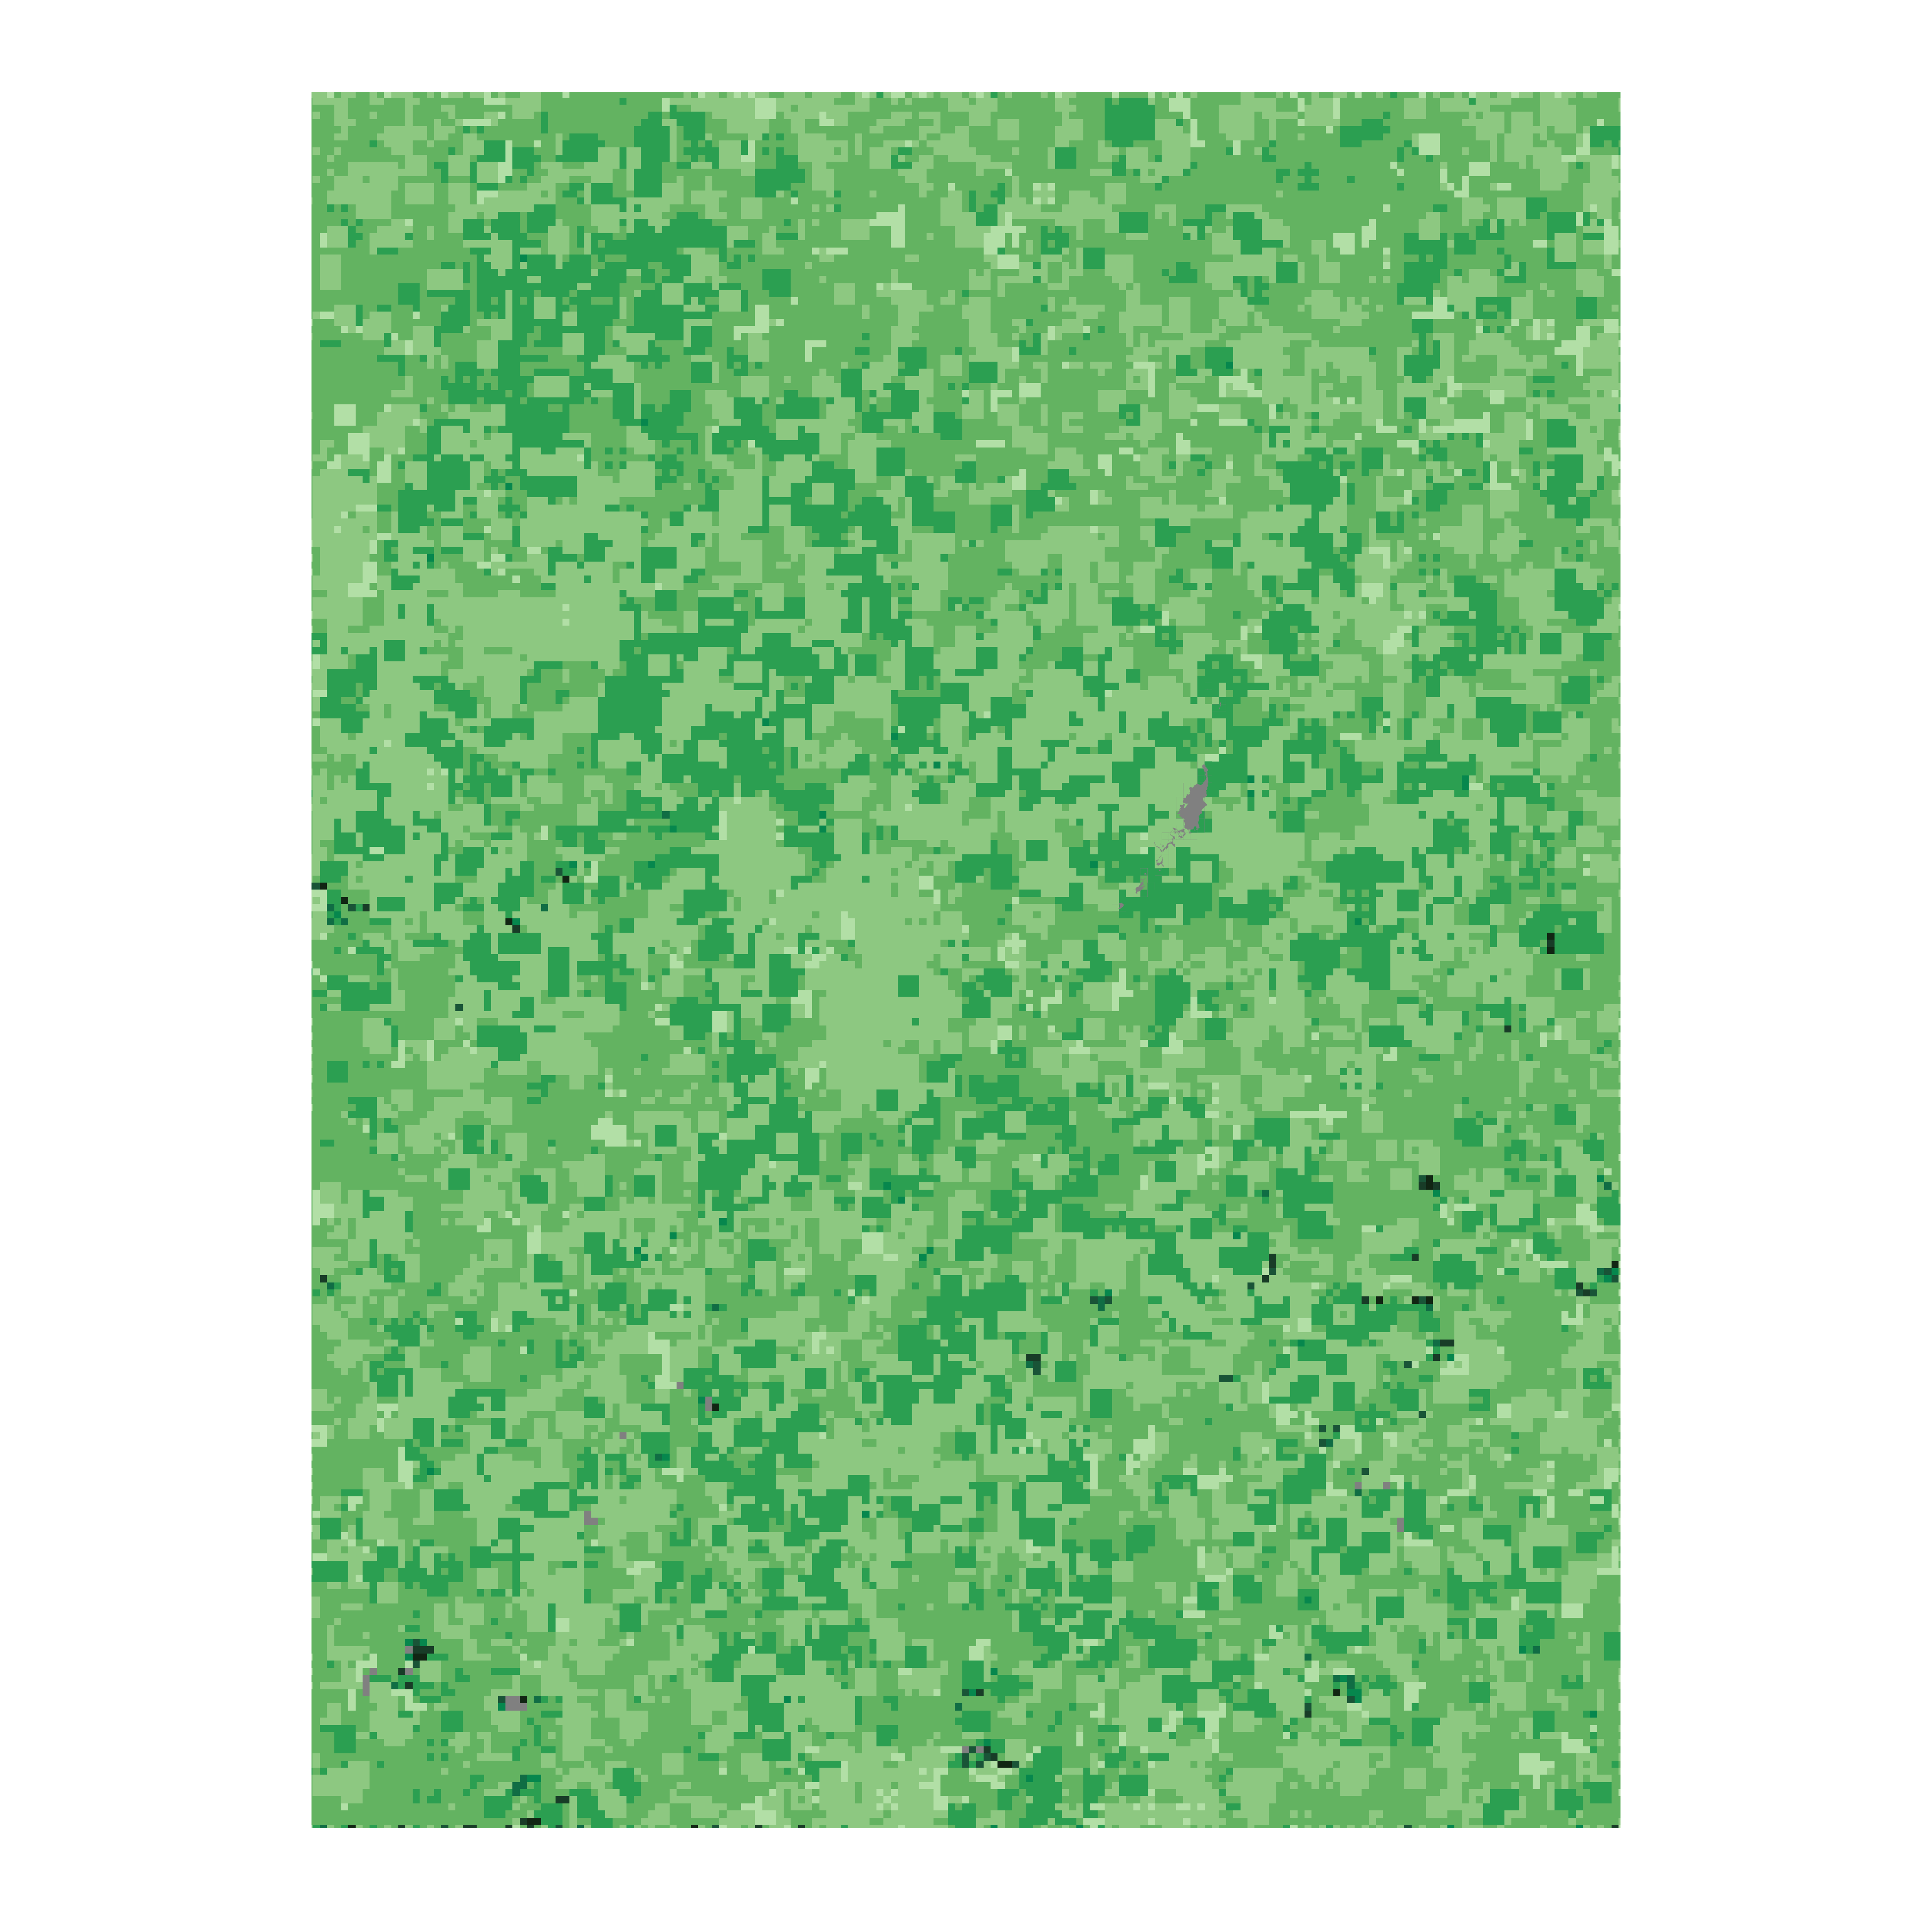

TypeError: Object of type Timestamp is not JSON serializable

In [227]:
getGridGeoJSON(chlor_a,'chlor_a_base')

In [17]:
import numpy as np
import pandas as pd
from scipy.interpolate import griddata
import branca
import matplotlib.pyplot as plt
import geojsoncontour
import geopandas as gpd
import json
import xarray as xr
import folium
import datetime as dt
from matplotlib.cm import ScalarMappable
from matplotlib.figure import Figure

In [94]:
def getGeoJSONContour(df):

#     df_slice = df[df['chlor_a_base'] == pd.to_datetime(time)]

    coordinates = df[['latitude','longitude','chlor_a_base']]
    coordinates = coordinates.drop_duplicates()

    x_orig = np.asarray(coordinates.longitude.tolist())
    y_orig = np.asarray(coordinates.latitude.tolist())
    z_orig = np.asarray(coordinates.chlor_a_base.tolist())

    colors = ["#112513", "#183c27", "#195437","#106d44","#06874d","#2b9f51","#63b361","#8dc881","#b2dfa6","#d7f9d0"]
    colors.reverse()
    x_arr          = np.linspace(np.min(x_orig), np.max(x_orig), 5000)
    y_arr          = np.linspace(np.min(y_orig), np.max(y_orig), 5000)
    x_mesh, y_mesh = np.meshgrid(x_arr, y_arr)
    z_mesh = griddata((x_orig, y_orig), z_orig, (x_mesh, y_mesh), method='linear')
    
    levels = len(colors)
    vmin   = -4
    vmax   = 1
    cm     = branca.colormap.LinearColormap(colors, vmin=vmin, vmax=vmax).to_step(levels)



    contourf = plt.contourf(x_mesh, y_mesh, z_mesh, levels, alpha=0.5, colors=colors, linestyles='None',antialiased=True, vmin=vmin, vmax=vmax)

    geojson = geojsoncontour.contourf_to_geojson(
        contourf=contourf,
        min_angle_deg=3.0,
        ndigits=5,
        stroke_width=1,
        fill_opacity=0.5)

    df2 = gpd.read_file('../palauEEZ.geojson')
    with open("contourplot_chlor.geojson", "w") as text_file:
        text_file.write(geojson)
    df1 = gpd.read_file("contourplot_chlor.geojson")
    df3 = gpd.read_file('../palau.geojson')
    df3 =df3.drop(['type','id','tags','meta'],axis = 1)
    df3 = df3[df3.geometry.type != 'LineString']
#     merged = gpd.overlay(df2,df1, how='intersection')
    merged = gpd.overlay(df1,df3, how='difference')
#     merged_json = merged.to_json()
#     merged = geojson

    R,G,B = [], [],[]
    for color in merged['fill'].tolist():
        r,g,b = [int(str(color[1:])[i:i+2], 16) for i in (0, 2, 4)]
        R.append(r)
        G.append(g)
        B.append(b)
    merged['R'] = R
    merged['G'] = G
    merged['B'] = B
    mergedrgb_json = merged.to_json()
    loaded = json.loads(mergedrgb_json)
#     print(merged)
    fig, ax = plt.subplots(figsize=(50, 50))
    boundary.plot(ax=ax, color="gray")
    merged.plot(ax=ax, color=merged["fill"])
    
    ax.axis("off")
    plt.axis('equal')
    plt.show()
    return loaded

In [92]:
chlor_a['chlor_a_base'] = np.log(chlor_a['chlor_a'])

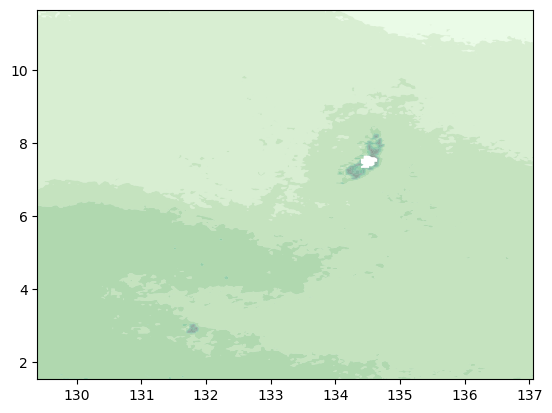

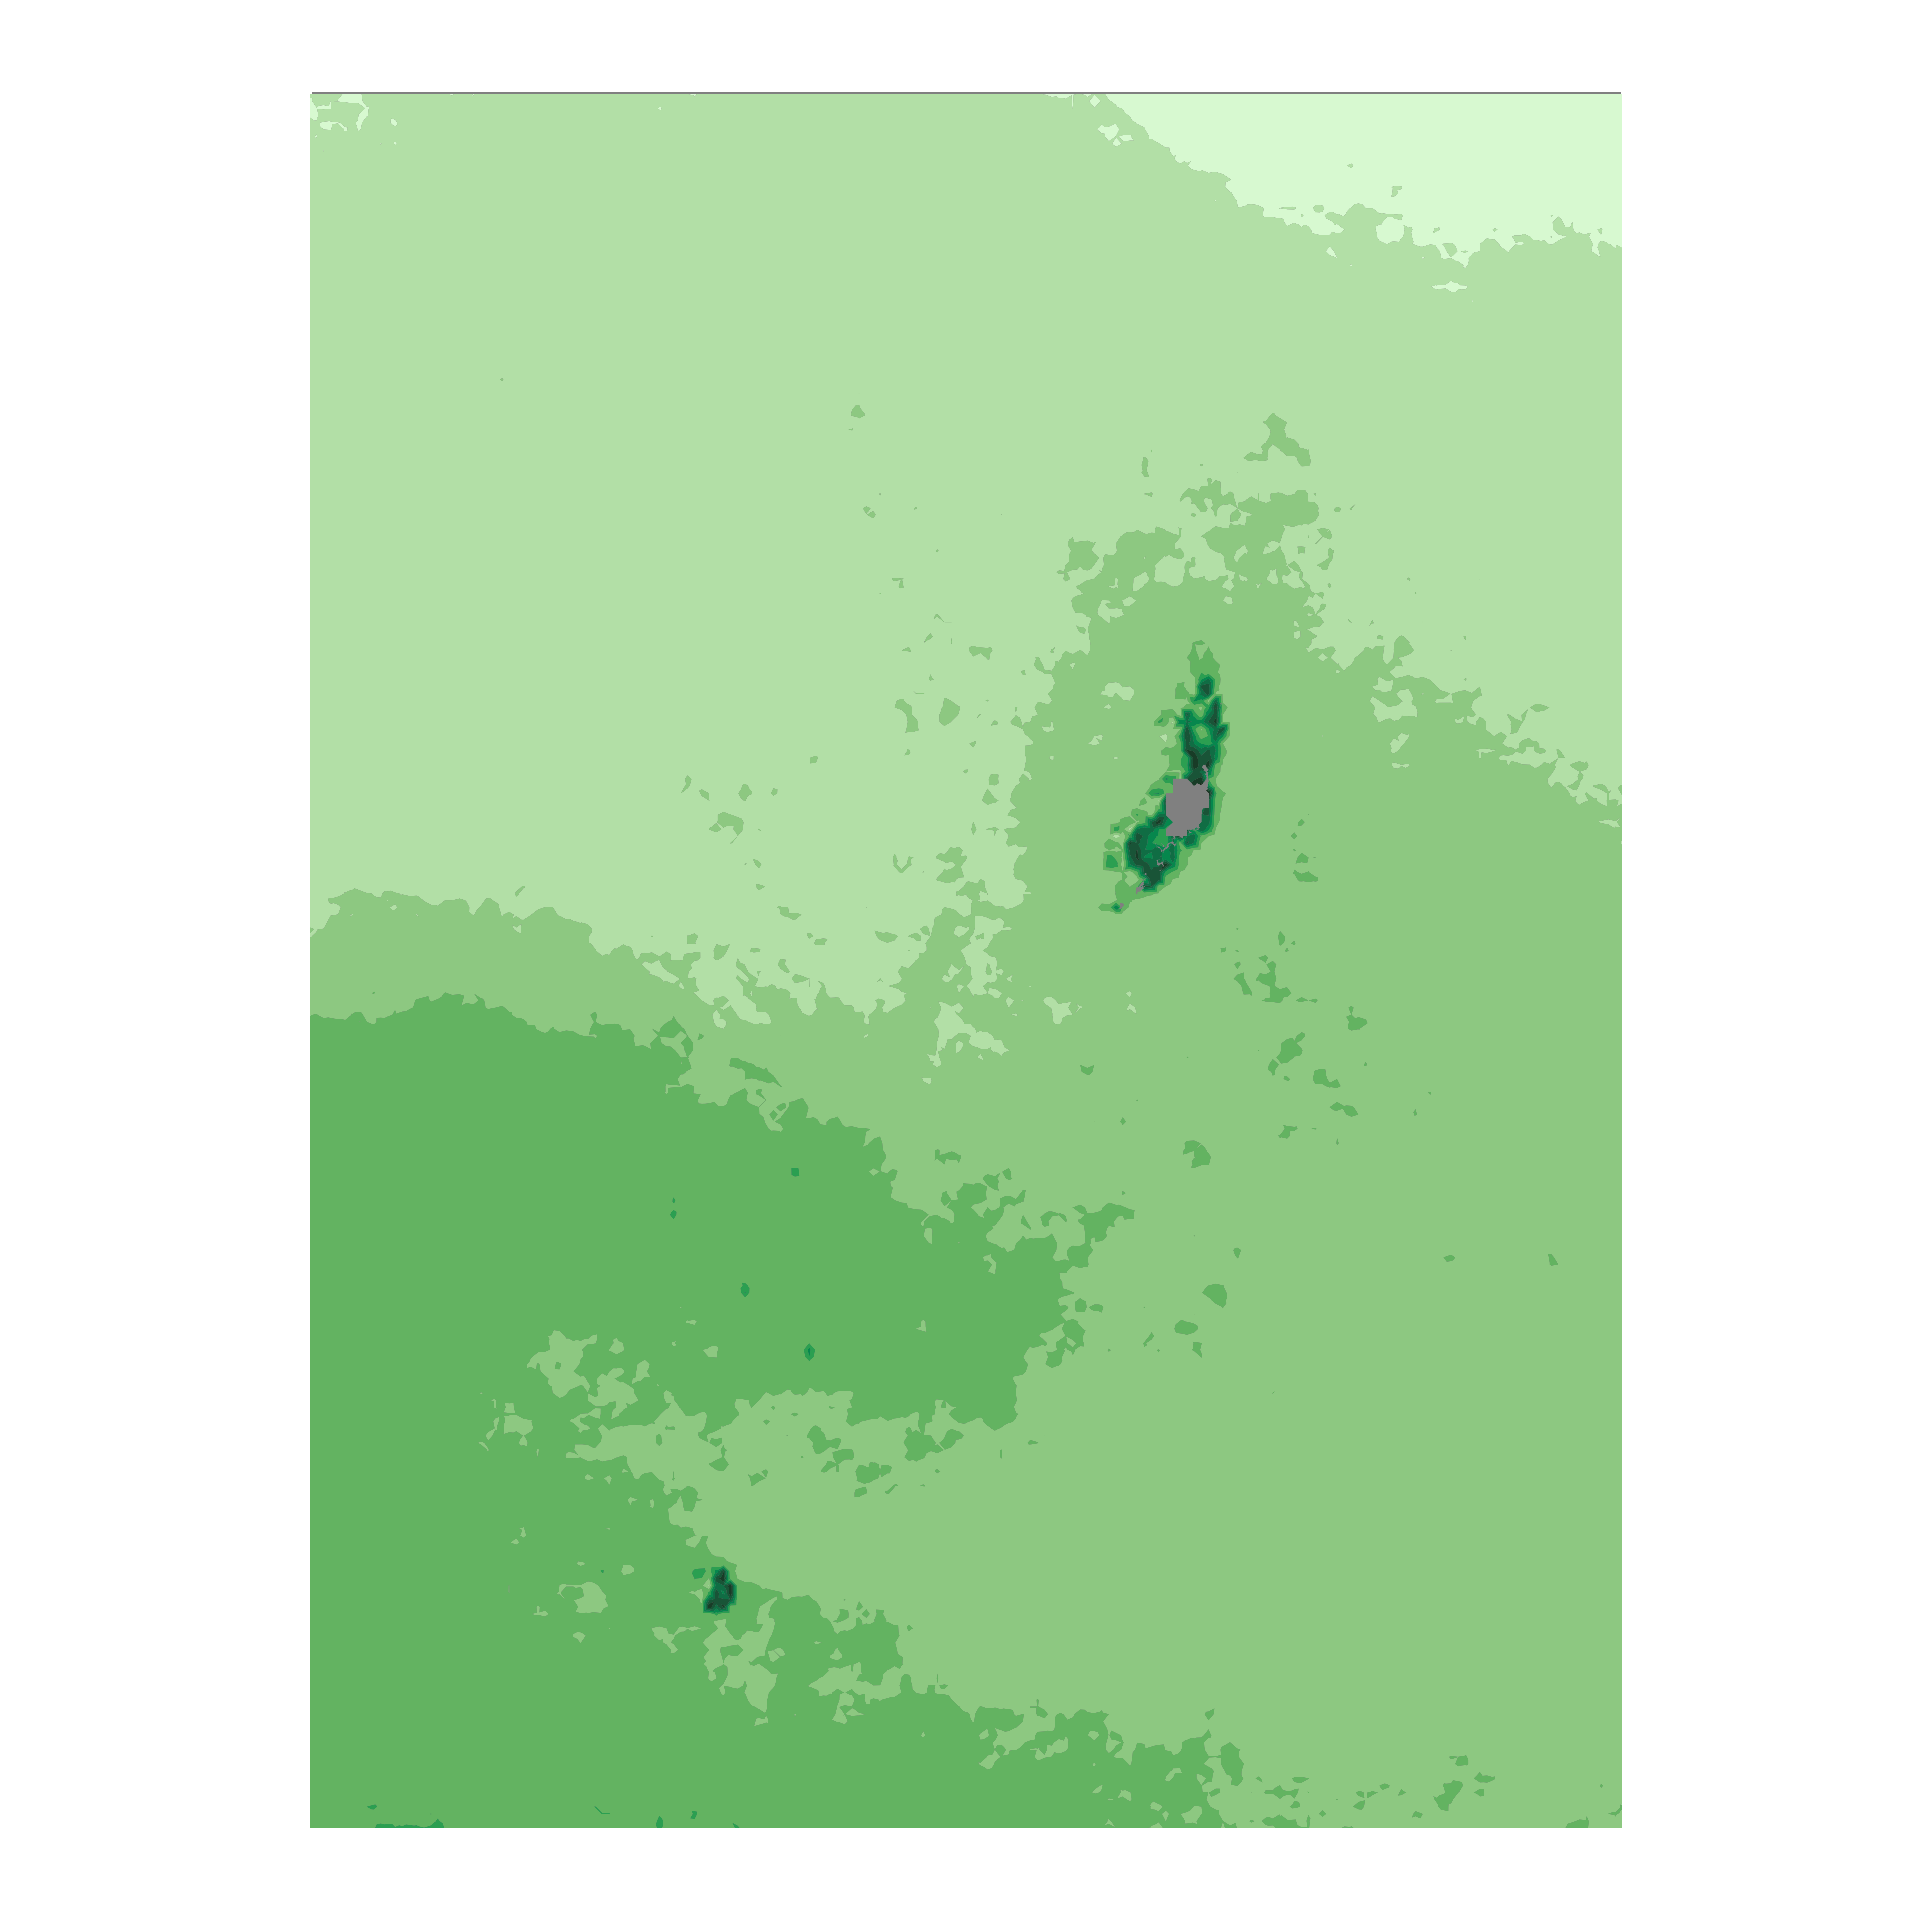

In [222]:
with open("./chlor_a_linear"+'.json', 'w') as f:
        json.dump(getGeoJSONContour(chlor_a), f)

In [305]:
def getGeoJSONContourLog(df):

#     df_slice = df[df['chlor_a_base'] == pd.to_datetime(time)]

    coordinates = df[['latitude','longitude','chlor_a_log10']]
    coordinates = coordinates.drop_duplicates()

    x_orig = np.asarray(coordinates.longitude.tolist())
    y_orig = np.asarray(coordinates.latitude.tolist())
    z_orig = np.asarray(coordinates.chlor_a_log10.tolist())
    colors = ['#112313',
 '#112413',
 '#112413',
 '#112513',
 '#142c19',
 '#16341f',
 '#183c27', '#19442c','#194c31','#195437','#165c3b','#13643f','#106d44','#0d7547','#0a7e4a','#06874d','#10914e','#1c994f','#2b9f51',
 '#39aa51',
 '#48b352',
 '#63b361',
 '#71ba6b',
 '#7fc176',
 '#8dc881',
 '#99d08d',
 '#a5d899',
 '#b2dfa6',
 '#bdeab2',
 '#c9f3c0']
    colors.reverse()
    x_arr          = np.linspace(np.min(x_orig), np.max(x_orig), 5000)
    y_arr          = np.linspace(np.min(y_orig), np.max(y_orig), 5000)
    x_mesh, y_mesh = np.meshgrid(x_arr, y_arr)
    z_mesh = griddata((x_orig, y_orig), z_orig, (x_mesh, y_mesh), method='linear')
#     tiers = np.logspace(start = -4,stop = 1,num = 31, base = 10).tolist()
#     levels = len(colors)
    tiers = np.logspace(start = -1.7371779278,stop = 0.434294481903,num = len(colors)+1, base = 10).tolist()
    vmin   = -1.7371779278
    vmax   = 0.434294481903
#     cm     = branca.colormap.LinearColormap(colors, vmin=vmin, vmax=vmax).to_step(n = levels,method = "linear")



    contourf = plt.contourf(x_mesh, y_mesh, z_mesh, 10, alpha=1,levels = levels, colors=colors, linestyles='None',antialiased=False, vmin=vmin, vmax=vmax)

    geojson = geojsoncontour.contourf_to_geojson(
        contourf=contourf,
        min_angle_deg=3.0,
        ndigits=5,
        stroke_width=1,
        fill_opacity=0.5)

    df2 = gpd.read_file('../palauEEZ.geojson')
    with open("contourplot_chlor.geojson", "w") as text_file:
        text_file.write(geojson)
    df1 = gpd.read_file("contourplot_chlor.geojson")
    df3 = gpd.read_file('../palau.geojson')
    df3 =df3.drop(['type','id','tags','meta'],axis = 1)
    df3 = df3[df3.geometry.type != 'LineString']
#     merged = gpd.overlay(df2,df1, how='intersection')
    merged = gpd.overlay(df1,df3, how='difference')
#     merged_json = merged.to_json()
#     merged = geojson

    R,G,B = [], [],[]
    for color in merged['fill'].tolist():
        r,g,b = [int(str(color[1:])[i:i+2], 16) for i in (0, 2, 4)]
        R.append(r)
        G.append(g)
        B.append(b)
    merged['R'] = R
    merged['G'] = G
    merged['B'] = B
    mergedrgb_json = merged.to_json()
    loaded = json.loads(mergedrgb_json)
#     print(merged)
    fig, ax = plt.subplots(figsize=(50, 50))
    boundary.plot(ax=ax, color="gray")
    merged.plot(ax=ax, color=merged["fill"])
    
    ax.axis("off")
    plt.axis('equal')
    plt.show()
    return loaded

In [71]:
chlor_a['chlor_a_log10'] = np.log10(chlor_a['chlor_a'])

In [72]:
chlor_a

latitude   longitude   chlor_a  chlor_a_base  chlor_a_log10
0      11.645833  129.395833  0.054558     -2.908500      -1.263145
1      11.645833  129.437500  0.054270     -2.913781      -1.265439
2      11.645833  129.479167  0.054466     -2.910171      -1.263871
3      11.645833  129.520833  0.054907     -2.902113      -1.260372
4      11.645833  129.562500  0.051083     -2.974302      -1.291723
...          ...         ...       ...           ...            ...
45135   1.520833  136.895833  0.131971     -2.025176      -0.879523
45136   1.520833  136.937500  0.130040     -2.039916      -0.885924
45137   1.520833  136.979167  0.127966     -2.055993      -0.892906
45138   1.520833  137.020833  0.127111     -2.062692      -0.895816
45139   1.520833  137.062500  0.127579     -2.059021      -0.894221

[45140 rows x 5 columns]

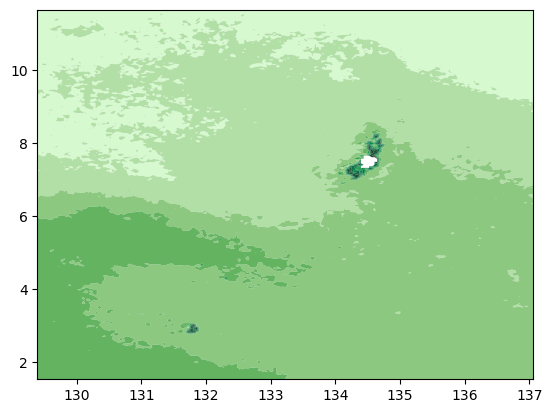

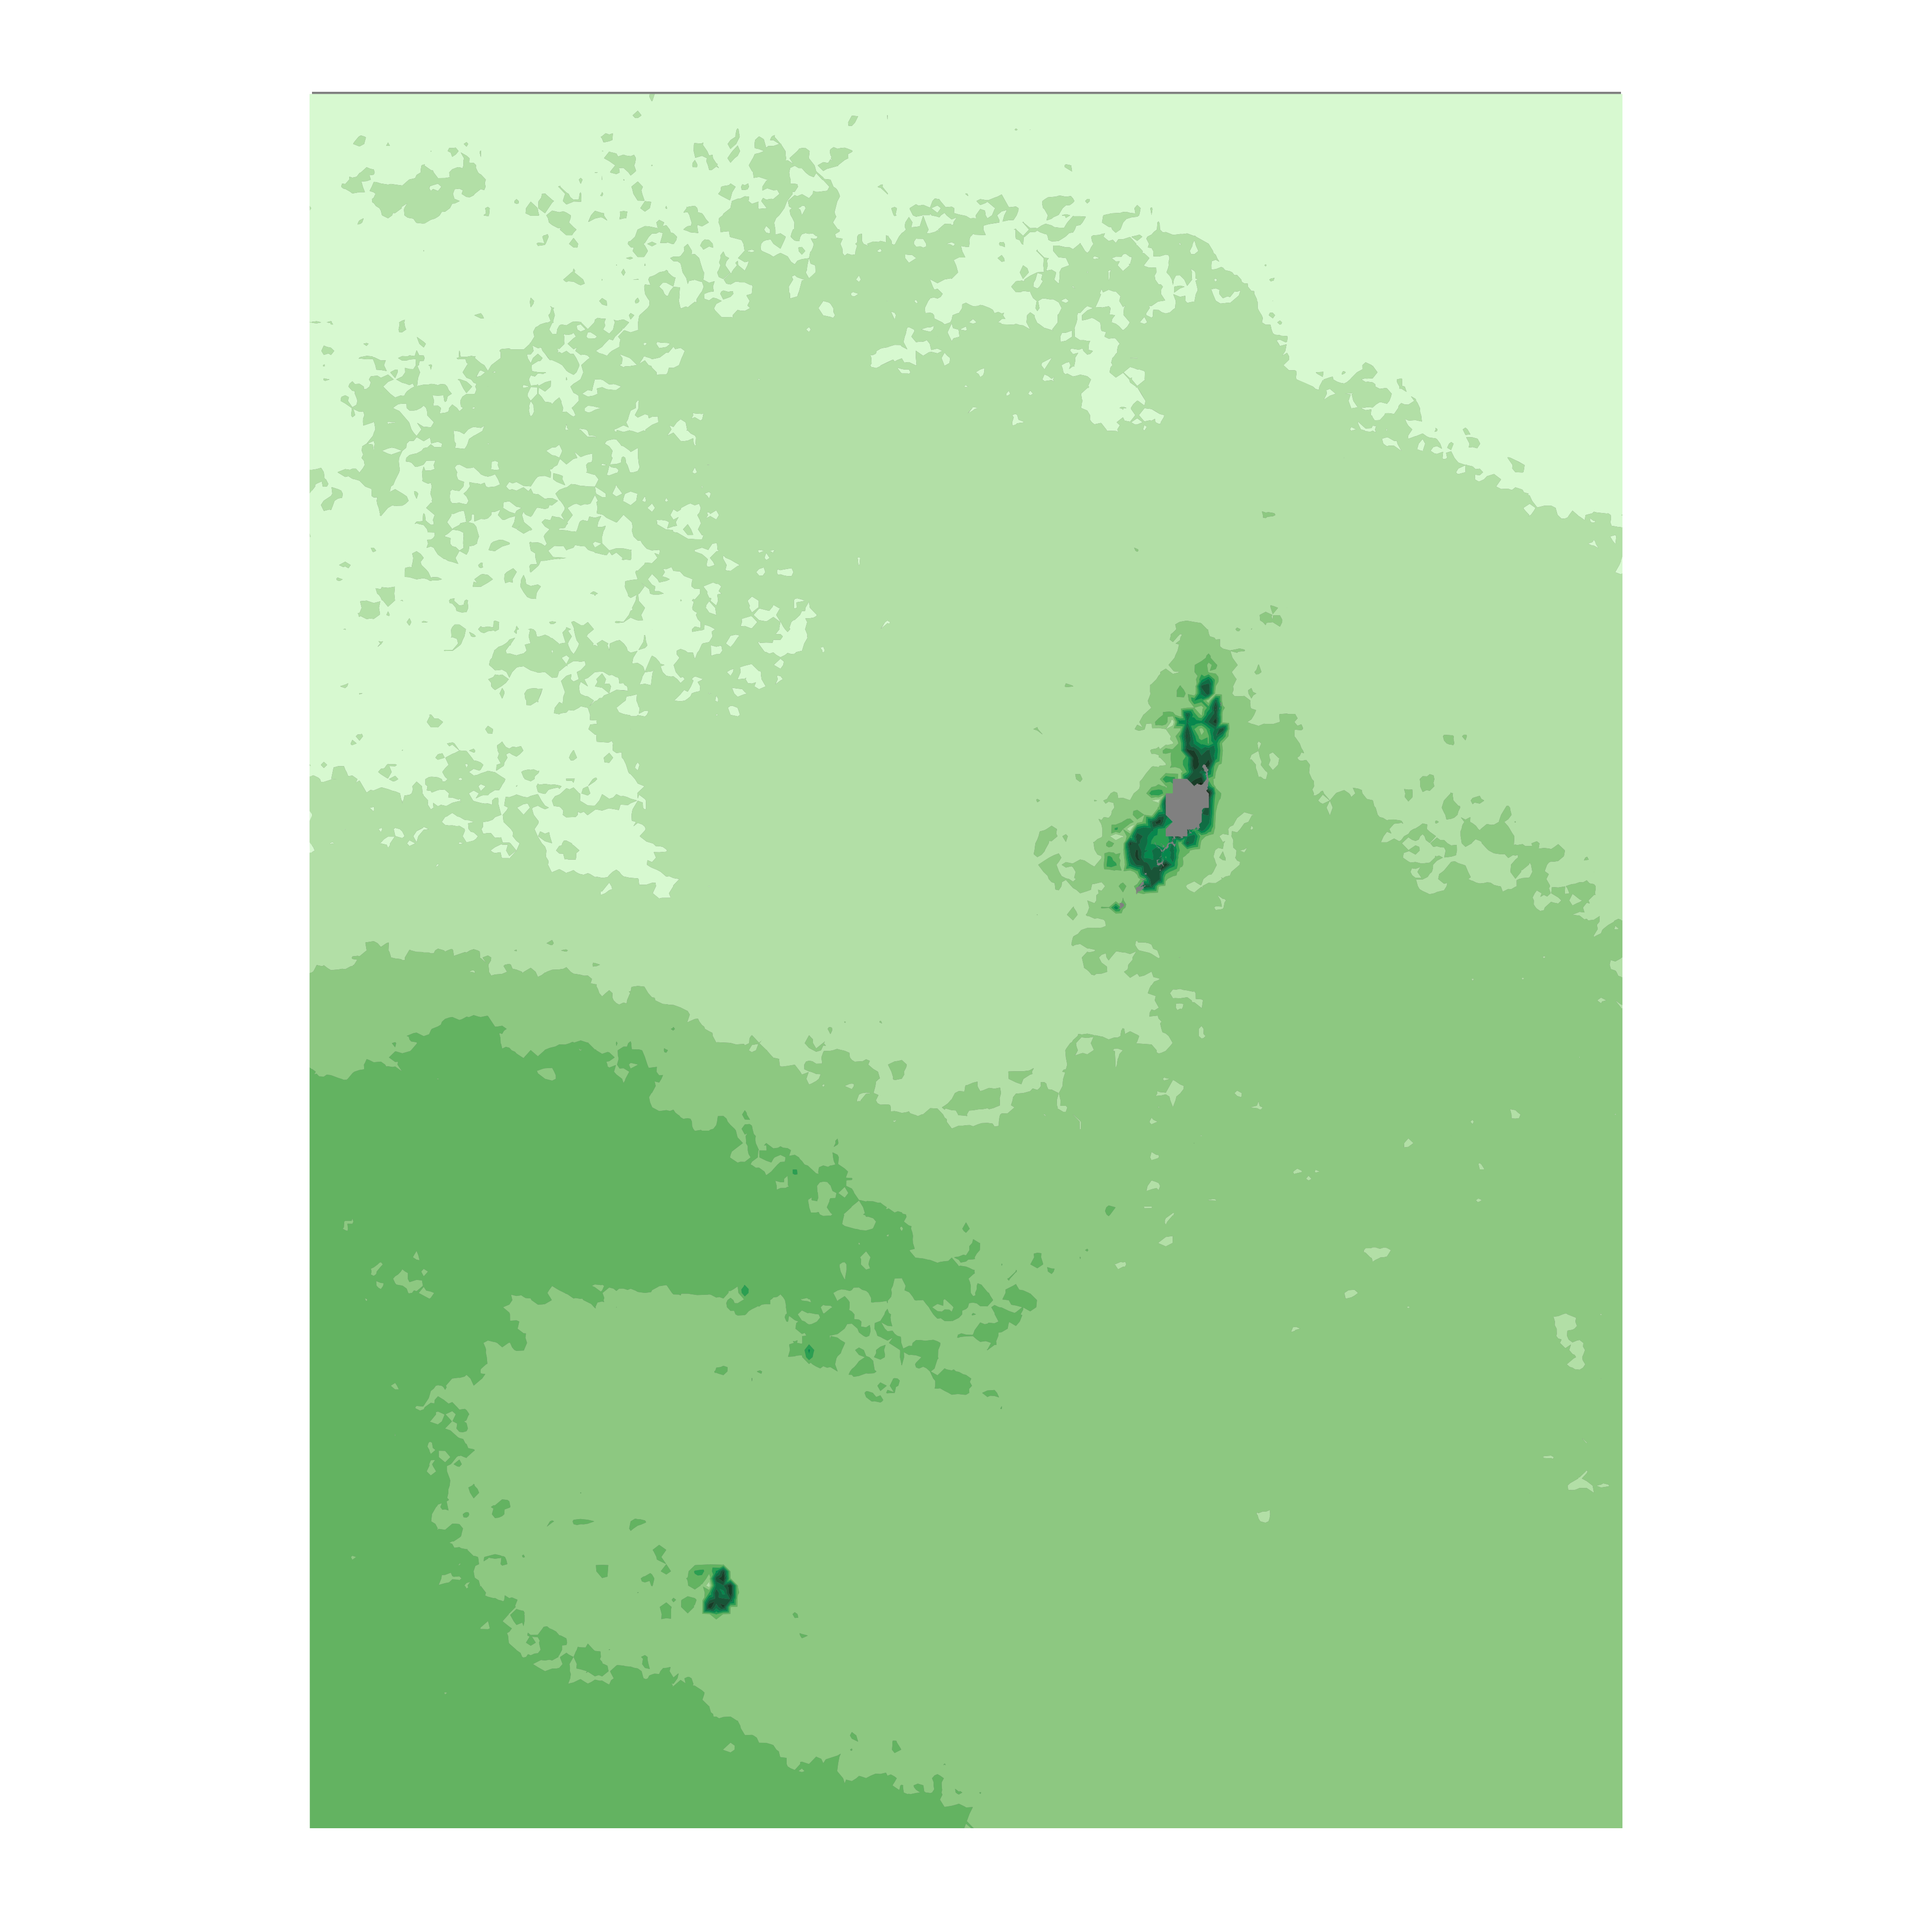

In [108]:
with open("./chlor_a"+'.json', 'w') as f:
        json.dump(getGeoJSONContourLog(chlor_a), f)

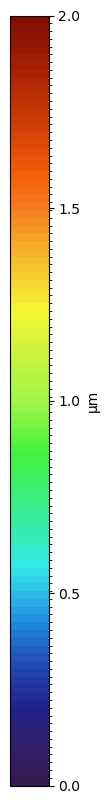

In [258]:
colors = colors = ['#7b0c02',
 '#810e02',
 '#871102',
 '#8d1403',
 '#921603',
 '#981a03',
 '#9e1d03',
 '#a42004',
 '#aa2404',
 '#af2704',
 '#b52b05',
 '#bb2f05',
 '#c13305',
 '#c63706',
 '#cc3c06',
 '#d24006',
 '#d84507',
 '#dd4a07',
 '#e34f08',
 '#e95408',
 '#ee5908',
 '#f45f09',
 '#f6650d',
 '#f66c13',
 '#f67219',
 '#f6791f',
 '#f68321',
 '#f68d22',
 '#f69724',
 '#f6a025',
 '#f6aa27',
 '#f6b329',
 '#f6bc2a',
 '#f6c52c',
 '#f6ce2e',
 '#f5d72f',
 '#f5e031',
 '#f5e832',
 '#f5f134',
 '#f2f536',
 '#eaf537',
 '#e2f539',
 '#daf53a',
 '#d2f53c',
 '#cbf53d',
 '#c3f53f',
 '#bcf541',
 '#b5f542',
 '#aef544',
 '#a7f545',
 '#a0f547',
 '#93f546',
 '#86f445',
 '#79f444',
 '#6bf343',
 '#5ef342',
 '#50f241',
 '#43f140',
 '#3ff148',
 '#3ef054',
 '#3df060',
 '#3cef6c',
 '#3bef78',
 '#3aee83',
 '#39ee8f',
 '#38ed9b',
 '#37eca7',
 '#36ecb4',
 '#35ebc0',
 '#34ebcc',
 '#33ead8',
 '#33eae5',
 '#32e1e9',
 '#31d3e8',
 '#30c6e8',
 '#2fb8e7',
 '#2aace5',
 '#259fe3',
 '#2092e0',
 '#2084d9',
 '#2077d2',
 '#216bca',
 '#2160c2',
 '#2156bb',
 '#224cb4',
 '#2243ac',
 '#223aa5',
 '#22339e',
 '#222c97',
 '#212590',
 '#232189',
 '#272182',
 '#2b207b',
 '#2e2075',
 '#301f6e',
 '#321e68',
 '#331d62',
 '#341c5b',
 '#341b55',
 '#331a4f']
colors.reverse()
levels = len(colors)
#     vmin   = min(coordinates.tos.tolist())
#     vmax   = max(coordinates.tos.tolist())
cmap = mpl.colors.ListedColormap(colors)
#     tiers = np.logspace(0,10,levels+1).tolist()
#     tiers = np.logspace(start = -4,stop = 1,num = levels, base = 10).tolist()
#     tiers = [0.0001,(0.001+0.0001)/2,0.001,,0.01,,0.1,,1,10]
# tiers = np.logspace(start = -1.7371779278,stop = 0.434294481903,num = len(colors)+1, base = 10).tolist()
#     vmin   = -1.7371779278
#     vmax   = 0.434294481903
tiers = list(np.linspace(0,2,num = len(colors)))
bounds = tiers
# bounds = [0.0,0.5,1.0,1.5,2.0]

norm = mpl.colors.BoundaryNorm(bounds, ncolors=len(colors))

cfig, ax = plt.subplots(figsize=(0.5,10))
#     cfig.subplots_adjust(bottom=0.5)
cfig.colorbar(ScalarMappable(norm=norm, cmap=cmap),cax = ax, orientation='vertical', spacing='uniform',ticks = [0.0,0.5,1.0,1.5,2.0], label = "μm")

#     cfig.savefig(full_directory)
cfig.savefig("../new_colorbar/Phyto_size_v.png",bbox_inches='tight', dpi=150)

In [291]:
def getGeoJSONContourMD(df):

#     df_slice = df[df['chlor_a_base'] == pd.to_datetime(time)]

    coordinates = df[['latitude','longitude','MD50']]
    coordinates = coordinates.drop_duplicates()

    x_orig = np.asarray(coordinates.longitude.tolist())
    y_orig = np.asarray(coordinates.latitude.tolist())
    z_orig = np.asarray(coordinates.MD50.tolist())

#     colors = ["#112513", "#183c27", "#195437","#106d44","#06874d","#2b9f51","#63b361","#8dc881","#b2dfa6","#d7f9d0"]
    colors = ['#7b0c02',
 '#810e02',
 '#871102',
 '#8d1403',
 '#921603',
 '#981a03',
 '#9e1d03',
 '#a42004',
 '#aa2404',
 '#af2704',
 '#b52b05',
 '#bb2f05',
 '#c13305',
 '#c63706',
 '#cc3c06',
 '#d24006',
 '#d84507',
 '#dd4a07',
 '#e34f08',
 '#e95408',
 '#ee5908',
 '#f45f09',
 '#f6650d',
 '#f66c13',
 '#f67219',
 '#f6791f',
 '#f68321',
 '#f68d22',
 '#f69724',
 '#f6a025',
 '#f6aa27',
 '#f6b329',
 '#f6bc2a',
 '#f6c52c',
 '#f6ce2e',
 '#f5d72f',
 '#f5e031',
 '#f5e832',
 '#f5f134',
 '#f2f536',
 '#eaf537',
 '#e2f539',
 '#daf53a',
 '#d2f53c',
 '#cbf53d',
 '#c3f53f',
 '#bcf541',
 '#b5f542',
 '#aef544',
 '#a7f545',
 '#a0f547',
 '#93f546',
 '#86f445',
 '#79f444',
 '#6bf343',
 '#5ef342',
 '#50f241',
 '#43f140',
 '#3ff148',
 '#3ef054',
 '#3df060',
 '#3cef6c',
 '#3bef78',
 '#3aee83',
 '#39ee8f',
 '#38ed9b',
 '#37eca7',
 '#36ecb4',
 '#35ebc0',
 '#34ebcc',
 '#33ead8',
 '#33eae5',
 '#32e1e9',
 '#31d3e8',
 '#30c6e8',
 '#2fb8e7',
 '#2aace5',
 '#259fe3',
 '#2092e0',
 '#2084d9',
 '#2077d2',
 '#216bca',
 '#2160c2',
 '#2156bb',
 '#224cb4',
 '#2243ac',
 '#223aa5',
 '#22339e',
 '#222c97',
 '#212590',
 '#232189',
 '#272182',
 '#2b207b',
 '#2e2075',
 '#301f6e',
 '#321e68',
 '#331d62',
 '#341c5b',
 '#341b55',
 '#331a4f']
    colors.reverse()
    x_arr          = np.linspace(np.min(x_orig), np.max(x_orig), 5000)
    y_arr          = np.linspace(np.min(y_orig), np.max(y_orig), 5000)
    x_mesh, y_mesh = np.meshgrid(x_arr, y_arr)
    z_mesh = griddata((x_orig, y_orig), z_orig, (x_mesh, y_mesh), method='linear')
    
    levels = list(np.linspace(0,2,num = len(colors)))
    vmin   = 0.0
    vmax   = 2.0
#     cm     = branca.colormap.LinearColormap(colors, vmin=vmin, vmax=vmax).to_step(levels)



    contourf = plt.contourf(x_mesh, y_mesh, z_mesh, levels, alpha=1,colors = colors, linestyles='None',antialiased=True, vmin=vmin, vmax=vmax)

    geojson = geojsoncontour.contourf_to_geojson(
        contourf=contourf,
        min_angle_deg=3.0,
        ndigits=5,
        stroke_width=1,
        fill_opacity=1)

    df2 = gpd.read_file('../palauEEZ.geojson')
    with open("contourplot_chlor.geojson", "w") as text_file:
        text_file.write(geojson)
    df1 = gpd.read_file("contourplot_chlor.geojson")
    df3 = gpd.read_file('../palau.geojson')
    df3 =df3.drop(['type','id','tags','meta'],axis = 1)
    df3 = df3[df3.geometry.type != 'LineString']
#     merged = gpd.overlay(df2,df1, how='intersection')
    merged = gpd.overlay(df1,df3, how='difference')
#     merged_json = merged.to_json()
#     merged = geojson

    R,G,B = [], [],[]
    for color in merged['fill'].tolist():
        r,g,b = [int(str(color[1:])[i:i+2], 16) for i in (0, 2, 4)]
        R.append(r)
        G.append(g)
        B.append(b)
    merged['R'] = R
    merged['G'] = G
    merged['B'] = B
    mergedrgb_json = merged.to_json()
    loaded = json.loads(mergedrgb_json)
#     print(merged)
    fig, ax = plt.subplots(figsize=(50, 50))
    boundary.plot(ax=ax, color="gray")
    merged.plot(ax=ax, color=merged["fill"])
    
    ax.axis("off")
    plt.axis('equal')
    plt.show()
    return loaded

In [264]:
ds = xr.open_dataset("../md50data/a50bd2a9c4f4e566799704213cf672af.nc")
sample_chlor_size = ds.to_dataframe().reset_index()

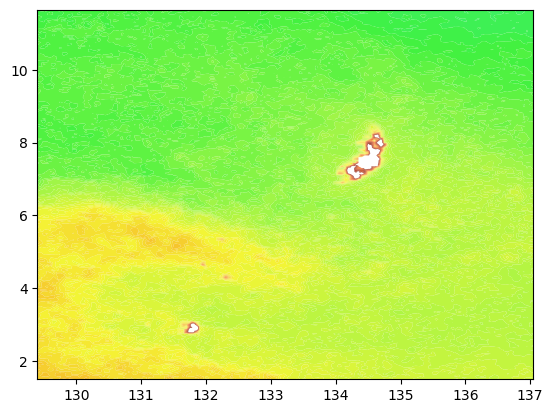

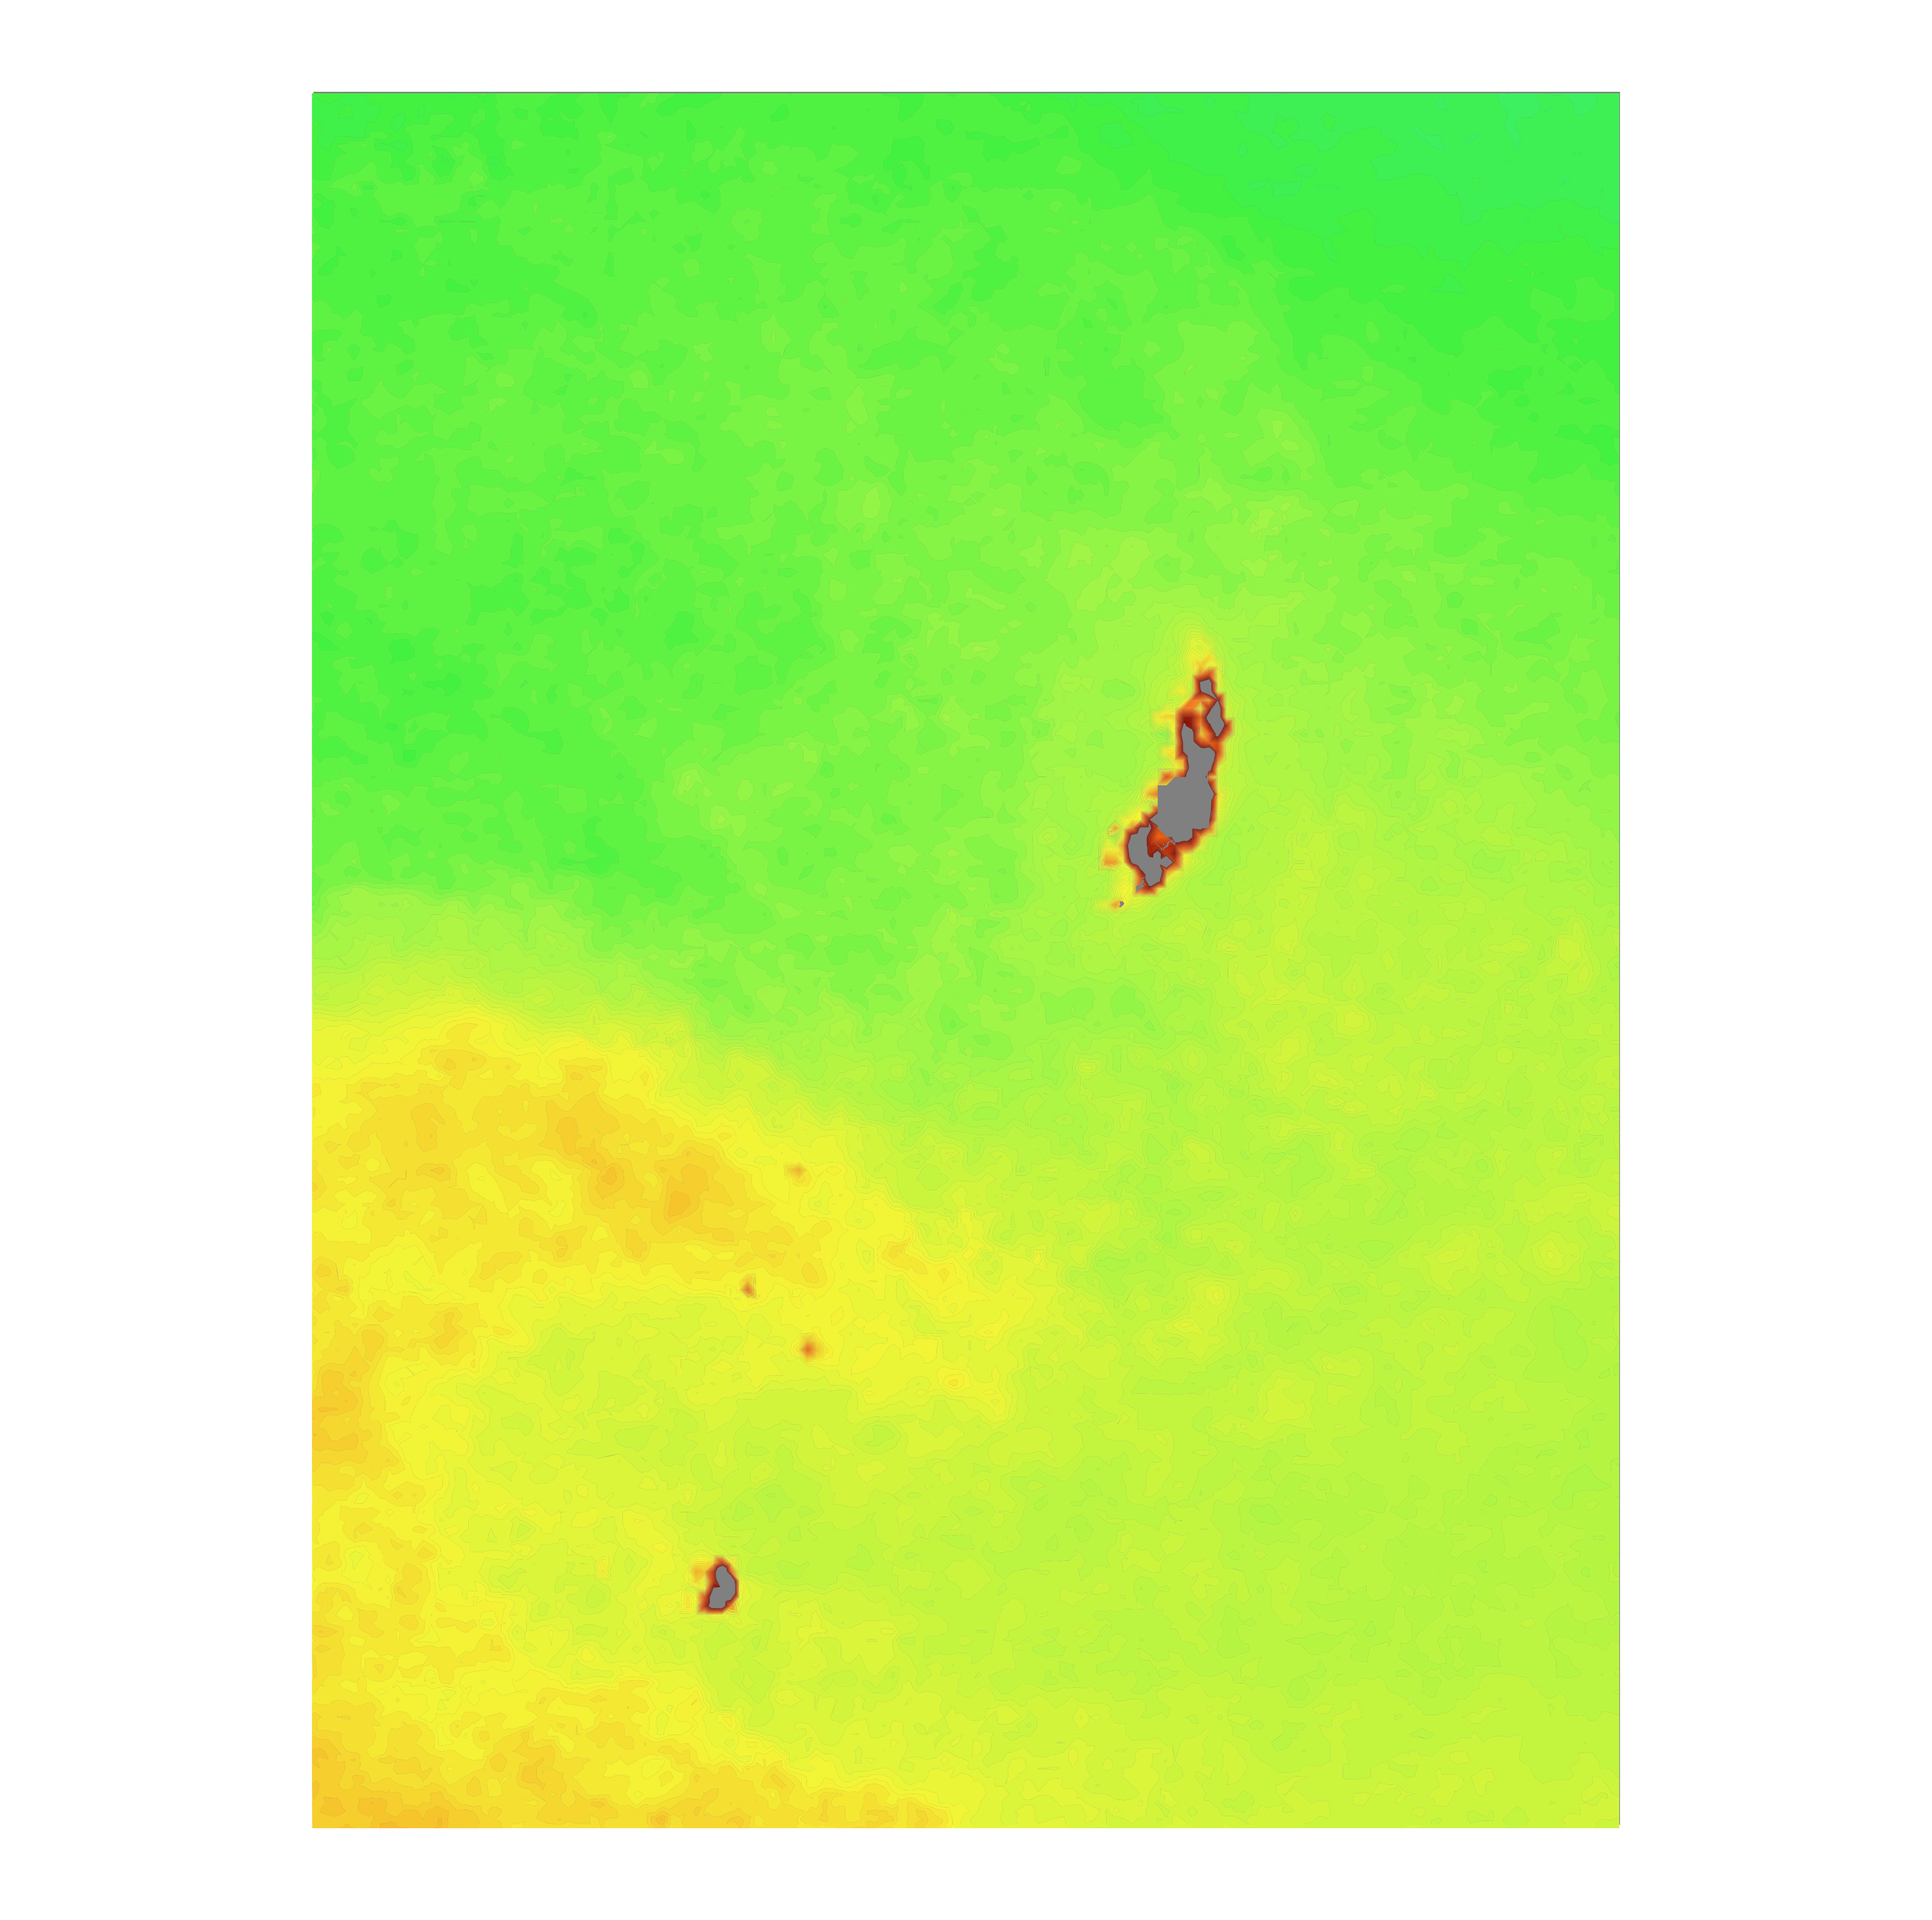

In [293]:
with open("./chlor_size"+'.json', 'w') as f:
        json.dump(getGeoJSONContourMD(sample_chlor_size), f)